In [6]:
%%capture
!unzip -o "/content/drive/MyDrive/Thesis/Dataset Backups/FaceForensics Extracted Faces/non_aligned.zip" -d /content/

# Preprocessing

In [2]:
import os
#os.environ['PYTHONHASHSEED'] = '0'

import tensorflow as tf
#tf.random.set_seed(89)

import numpy as np
#np.random.seed(42)

import random as rn
#rn.seed(1254)

## Parameters

In [4]:
BATCH_SIZE = 32
SIZE = 128
TRAINING_EPOCHS = 5
TUNING_EPOCHS = 15

input_shape = (SIZE, SIZE, 3)
learning_rate = 0.001
tuning_learning_rate = 0.00002

## Store into tf.data.Dataset

### FaceForensics++

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

dir_train = os.path.join('non_aligned', 'training')
dir_val = os.path.join('non_aligned', 'validation')
dir_test = os.path.join('non_aligned', 'testing')
image_format = '.jpg'

training_dataset = image_dataset_from_directory(
    dir_train,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=True,
    
)

validation_dataset = image_dataset_from_directory(
    dir_val,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=True,
    
)


Found 387185 files belonging to 2 classes.
Found 27978 files belonging to 2 classes.


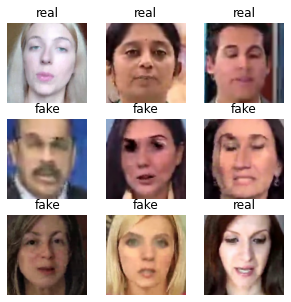

In [5]:
import matplotlib.pyplot as plt

class_names = training_dataset.class_names

plt.figure(figsize=(5, 5))
for images, labels in training_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

training_dataset = training_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of train batches: %d' % tf.data.experimental.cardinality(training_dataset))

Number of validation batches: 875
Number of train batches: 12100


In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

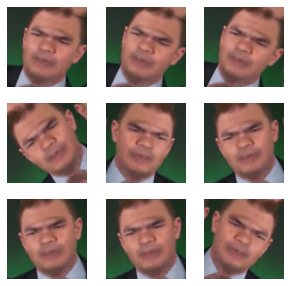

In [9]:
for image, _ in training_dataset.take(1):
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Model

XceptionNet [14] is a traditional CNN trained on ImageNet based on separable convolutions with residual connections. We transfer it to our task by replacing the final
fully connected layer with two outputs. The other layers are
initialized with the ImageNet weights. To set up the newly
inserted fully connected layer, we fix all weights up to the final layers and pre-train the network for 3 epochs. After this
step, we train the network for 15 more epochs and choose
the best performing model based on validation accuracy.

## Callbacks

In [20]:
from tensorflow import keras

# This function keeps the initial learning rate for the first ten epochs  
# and decreases it exponentially after that.  
def scheduler(epoch, lr):
    print("{0:.8f}".format(lr))
    return lr
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=7,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Thesis/Training Data/saved_models/XceptionNet-Binary-{epoch:02d}-{val_accuracy:.4f}.h5", #File name includes epoch and validation accuracy.,
    save_weights_only=False,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

## Compile Model

XceptionNet [14]- based approach is trained with a learning-rate of 0:0002 and a batch-size of 32. All detection methods are trained with the Adam optimizer using the default values for the moments (β1 = 0:9, β2 = 0:999,  = 10−8). We compute validation accuracies ten times per epoch and stop the training process if the validation accuracy does not change for 10 consecutive checks. Validation and test accuracies are computed on 100 images per video, training is evaluated on 270 images per video to account for frame count imbalance in our videos. Finally, we solve the imbalance between real and fake images in the binary task (i.e., the number of fake images being roughly four times as large as the number of pristine images) by weighing the training images correspondingly.

### Preprocess Input

In [11]:
preprocess_input = tf.keras.applications.xception.preprocess_input 

### Base Model

In [12]:
''' Instantiate a base model with pre-trained weights. '''
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=input_shape,
    include_top=False)  # Do not include the ImageNet classifier at the top.

''' Then, freeze the base model. '''
base_model.trainable = False

base_model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
__________________________

### Add Dense layer on top

In [13]:
''' Create a new model on top. '''
inputs = keras.Input(shape=input_shape)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

''' Compile model '''
model.compile(
    optimizer=keras.optimizers.Adam(lr = learning_rate),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_____________________________________________

## Train the top layer

In [14]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

875/875 [==============================] - 39s 36ms/step - loss: 0.7417 - accuracy: 0.4713
initial loss: 0.74
initial accuracy: 0.47


In [15]:
history = model.fit(training_dataset,
                    epochs=TRAINING_EPOCHS,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping])


Epoch 1/5
12100/12100 [==============================] - 692s 57ms/step - loss: 0.4967 - accuracy: 0.7315 - val_loss: 0.6587 - val_accuracy: 0.6731
Epoch 2/5
12100/12100 [==============================] - 591s 49ms/step - loss: 0.4468 - accuracy: 0.7728 - val_loss: 0.6965 - val_accuracy: 0.6770
Epoch 3/5
12100/12100 [==============================] - 584s 48ms/step - loss: 0.4344 - accuracy: 0.7817 - val_loss: 0.7272 - val_accuracy: 0.6800
Epoch 4/5
12100/12100 [==============================] - 588s 49ms/step - loss: 0.4290 - accuracy: 0.7863 - val_loss: 0.7475 - val_accuracy: 0.6757
Epoch 5/5
12100/12100 [==============================] - 591s 49ms/step - loss: 0.4260 - accuracy: 0.7889 - val_loss: 0.7632 - val_accuracy: 0.6762


## Training and Validation Graphs

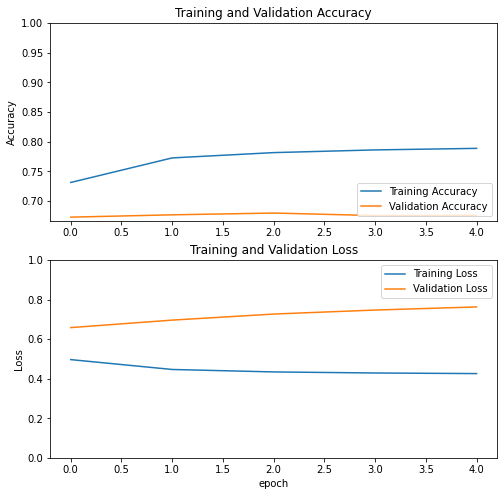

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

plt.savefig('/content/drive/MyDrive/Thesis/Training Data/training graph.png')

## Fine Tuning

Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.

Importantly, although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

### Recompile and set model as Trainable

In [17]:

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(lr = tuning_learning_rate),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
____________________________________________

In [18]:
import keras.backend as K
print(K.eval(model.optimizer.lr))

2e-05


### Fine Tuning loop

In [ ]:
total_epochs =  TRAINING_EPOCHS + TUNING_EPOCHS
history_fine = model.fit(training_dataset,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=validation_dataset,
                    callbacks=[early_stopping, checkpoint, lr_scheduler])


Epoch 5/20
0.00002000
12100/12100 [==============================] - 1692s 140ms/step - loss: 0.0074 - accuracy: 0.9973 - val_loss: 0.6185 - val_accuracy: 0.9159

Epoch 00005: val_accuracy improved from -inf to 0.91590, saving model to /content/drive/MyDrive/Thesis/Training Data/saved_models/XceptionNet-Binary-05-0.9159.h5
Epoch 6/20
0.00002000
12100/12100 [==============================] - 1699s 140ms/step - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.5221 - val_accuracy: 0.9217

Epoch 00006: val_accuracy improved from 0.91590 to 0.92165, saving model to /content/drive/MyDrive/Thesis/Training Data/saved_models/XceptionNet-Binary-06-0.9217.h5
Epoch 7/20
0.00002000
12100/12100 [==============================] - 1694s 140ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.4641 - val_accuracy: 0.9231

Epoch 00007: val_accuracy improved from 0.92165 to 0.92308, saving model to /content/drive/MyDrive/Thesis/Training Data/saved_models/XceptionNet-Binary-07-0.9231.h5
Epoch 8/20
0.000020

## Training and Validation Graphs

In [1]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([TRAINING_EPOCHS-1,TRAINING_EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([TRAINING_EPOCHS-1,TRAINING_EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

plt.savefig('/content/drive/MyDrive/Thesis/Training Data/tuning graph.png')

# Prediction

## Store into tf.data.Dataset

In [11]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Thesis/Training Data/saved_models/XceptionNet-Binary-11-0.9415.h5')

In [15]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

dir_train = os.path.join('non_aligned', 'training')
dir_val = os.path.join('non_aligned', 'validation')
dir_test = os.path.join('non_aligned', 'testing')
image_format = '.jpg'

test_dataset = image_dataset_from_directory(
    dir_test,
    color_mode="rgb",
    batch_size = 1000,
    image_size=(SIZE, SIZE),
    shuffle=True,
)

class_names = test_dataset.class_names
target_names=test_dataset.class_names
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 28000 files belonging to 2 classes.


In [12]:

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

28/28 [==============================] - 83s 2s/step - loss: 0.4953 - accuracy: 0.9354
Test accuracy : 0.9353571534156799


## Make Prediction

In [17]:
import numpy as np

#Retrieve a batch of images from the test set
labels = []
for img, label in (test_dataset.as_numpy_iterator()):
    labels.append(label)
labels = np.concatenate(labels).flatten()
predictions = model.predict(test_dataset).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
predictions = predictions.numpy()

print('Predictions:\n', predictions)
print('Predictions:\n', labels)


KeyboardInterrupt: ignored

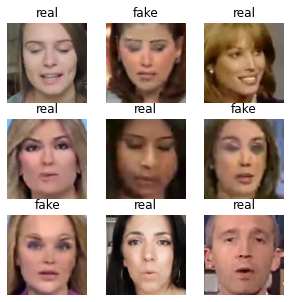

In [18]:
import matplotlib.pyplot as plt

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions_batch = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions_batch = tf.nn.sigmoid(predictions_batch)
predictions_batch = tf.where(predictions_batch < 0.5, 0, 1)
predictions_batch = predictions_batch.numpy()

plt.figure(figsize=(5, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions_batch[i]])
  plt.axis("off")

## Classification Report

In [19]:
from sklearn.metrics import classification_report
classificationReport = classification_report(label_batch, predictions_batch, target_names=target_names, digits=5)
print(classificationReport)

              precision    recall  f1-score   support

        fake    0.95208   0.92886   0.94033       492
        real    0.93269   0.95472   0.94358       508

    accuracy                        0.94200      1000
   macro avg    0.94239   0.94179   0.94195      1000
weighted avg    0.94223   0.94200   0.94198      1000



## Confusion Matrix

In [20]:
#Output confusion matrix
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    return cm
    
confusionMatrix = print_confusion_matrix(label_batch, predictions_batch)

True positive =  457
False positive =  35
False negative =  23
True negative =  485


# Write to File

In [21]:
import os

tp = str('True positive = '+ str(confusionMatrix[0][0]) + '\n')
fp = str('False positive = '+ str(confusionMatrix[0][1]) + '\n')
fn = str('False negative = '+ str(confusionMatrix[1][0]) + '\n')
tn = str('True negative = '+ str(confusionMatrix[1][1]) + '\n')

data = (
    'Model Name: ' + 'XceptionNet' + '\n' +
    'Batch Size: ' + str(BATCH_SIZE) + '\n' +
    'Image Size: ' + str(SIZE) + '\n' +
    'Training Epochs: ' + str(TRAINING_EPOCHS) + '\n' +
    'Tuning Epochs: ' + str(TUNING_EPOCHS) + '\n' +
    '===================================================== \n\n' +
    str(classificationReport) + '\n' + str(tp + fp + fn + tn)
)

from datetime import datetime 
import pytz 
  
# get the standard UTC time  
UTC = pytz.utc 
  
# it will get the time zone  
# of the specified location 
IST = pytz.timezone('Asia/Kolkata') 
  
datetime_ist = datetime.now(IST) 
filename = ('Report ' + datetime_ist.strftime('%Y-%m-%d %H%M') + ' Xception' + '.txt')

myFile = open('/content/drive/MyDrive/Thesis/Training Data/' + filename, 'w')
myFile.write(data)
myFile.close()

modelName = 'Xception ' + datetime_ist.strftime('%Y-%m-%d %H%M') + '.h5'
model.save('/content/drive/MyDrive/Thesis/Training Data/' + modelName)



In [ ]:
from google.colab import files
'''
files.download(filename)
files.download(modelName)
files.download('training graph.png')
files.download('tuning graph.png')
'''